In [1]:
import os
import cv2
import sys
import random

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm


import torchvision
import torchvision.transforms as transforms

sys.path.append('../')
from models.vit import *

/home/beomgon/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42) # Seed 고정

In [3]:
epochs = 90
batch_size = 64
momentum = 0.9
lr = 0.00005
weight_decay = 1e-4
img_size = 32
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_workers = os.cpu_count()
saved = '../saved/cifar_net_32.pth'

In [4]:
train_transforms = transforms.Compose([
                    transforms.ColorJitter(0.1,0.1,0.1,0.1),
                    transforms.RandomHorizontalFlip(0.5),
                    transforms.RandomResizedCrop(img_size, scale=(0.5, 1.0), ratio=(0.75, 1.25)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
test_transforms = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [5]:
train_dataset = torchvision.datasets.CIFAR10('../dataset', train=True, download=True, transform=train_transforms)
test_dataset = torchvision.datasets.CIFAR10('../dataset', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [7]:
images, targets = next(iter(train_loader))
images.shape, targets

(torch.Size([64, 3, 32, 32]),
 tensor([6, 0, 4, 1, 2, 7, 9, 4, 7, 8, 4, 5, 6, 0, 4, 2, 0, 1, 6, 1, 4, 3, 2, 3,
         2, 4, 0, 7, 5, 1, 8, 6, 3, 3, 7, 0, 4, 1, 7, 1, 3, 1, 1, 5, 6, 3, 7, 8,
         2, 3, 4, 8, 2, 1, 5, 6, 9, 9, 6, 9, 8, 3, 4, 7]))

In [8]:
model_args = dict(img_size=img_size, 
                  patch_size=8, 
                  embed_dim=192, 
                  depth=12, 
                  num_heads=2, 
                  checkpoint='', 
                  qk_norm=True, 
                  v_norm=True, 
                  patch_stride=4,
                  roll=True)
model =  vit_small_patch8_32(**model_args)

In [9]:
out = model(images)
out.shape

torch.Size([64, 10])

In [10]:
# for name, param in model.named_parameters():
#     print(name, param.requires_grad)

In [11]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    
    

In [12]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


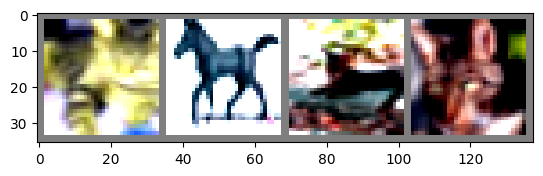

In [13]:
imshow(torchvision.utils.make_grid(images[:4]))

In [14]:

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, )
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=5, 
#                                         step_size_down=None, mode='exp_range', gamma=0.995)
from utils.scheduler import CosineAnnealingWarmUpRestarts
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=30, T_mult=1, eta_max=0.1,  T_up=6, gamma=0.25)

model = model.to(device)

In [15]:
from utils.train import get_acc

In [ ]:
best_acc = 0.
val_acc_list = []
for epoch in (range(epochs)):
    running_loss = []
    model.train()
    for i, data in (enumerate(train_loader)):
        images, targets = data
        images, targets = images.to(device), targets.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.item())
    # print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
    test_acc = get_acc(test_loader, model, device)
    val_acc_list.append(test_acc)
    if best_acc < test_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), saved)

    lr = optimizer.param_groups[0]['lr']
    print(f'{epoch + 1} loss: {sum(running_loss)/len(running_loss):.3f} acc: {test_acc:.2f} lr: {lr:.5f}')
    if scheduler :
        scheduler.step()


1 loss: 2.011 acc: 33.39 lr: 0.00005
2 loss: 1.729 acc: 44.06 lr: 0.01671
3 loss: 1.513 acc: 46.11 lr: 0.03337
4 loss: 1.414 acc: 51.38 lr: 0.05003
5 loss: 1.355 acc: 51.76 lr: 0.06668
6 loss: 1.299 acc: 56.06 lr: 0.08334
7 loss: 1.251 acc: 58.81 lr: 0.10000
8 loss: 1.193 acc: 59.69 lr: 0.09957
9 loss: 1.128 acc: 59.50 lr: 0.09830
10 loss: 1.076 acc: 62.95 lr: 0.09620
11 loss: 1.026 acc: 63.25 lr: 0.09330
12 loss: 0.984 acc: 65.20 lr: 0.08967
13 loss: 0.948 acc: 67.87 lr: 0.08536
14 loss: 0.903 acc: 68.76 lr: 0.08045
15 loss: 0.872 acc: 66.80 lr: 0.07501
16 loss: 0.844 acc: 68.81 lr: 0.06915
17 loss: 0.803 acc: 72.49 lr: 0.06296
18 loss: 0.769 acc: 72.18 lr: 0.05655
19 loss: 0.740 acc: 72.80 lr: 0.05003
20 loss: 0.707 acc: 74.31 lr: 0.04350
21 loss: 0.676 acc: 75.68 lr: 0.03709
22 loss: 0.645 acc: 76.28 lr: 0.03090
23 loss: 0.618 acc: 77.20 lr: 0.02504


In [ ]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,5]
plt.plot(val_acc_list, label='val_acc')
plt.legend()


In [ ]:
from utils.train import get_all_preds
test_preds = get_all_preds(model.to('cpu'), test_loader)
actual_labels = torch.Tensor(test_dataset.targets)
preds_correct = test_preds.argmax(dim=1).eq(actual_labels).sum().item()

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(test_dataset))

In [ ]:
from utils.visualize import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_dataset.targets, test_preds.argmax(dim=1))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, classes)

In [ ]:
vis_transforms = transforms.Compose([
                    transforms.Resize((img_size, img_size)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [ ]:
input_tensor.device

In [ ]:
# model

In [ ]:

from utils.visualize import VITAttentionRollout, show_mask_on_image
discard_ratio = 0.99 
head_fusion = 'min'
img = Image.open('dog_cat.png')
img = img.resize((224, 224))
input_tensor = vis_transforms(img).unsqueeze(0).to(device)
model.to(device)

attention_rollout = VITAttentionRollout(model, head_fusion=head_fusion, 
            discard_ratio=discard_ratio)
mask = attention_rollout(input_tensor)
name = "attention_rollout_{:.3f}_{}.png".format(discard_ratio, head_fusion)


np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)
# cv2.imshow("Input Image", np_img)
# cv2.imshow(name, mask)
plt.imshow(img)
plt.show()
# plt.imshow(name, mask)
# cv2.imwrite("input.png", np_img)
# cv2.imwrite(name, mask)
# cv2.waitKey(-1)


In [ ]:
plt.imshow(mask)
plt.show()